<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019-07-22-GRU_1layer-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRUPrototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12B%20-%20Project%2011%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20CNNs.ipynb


Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2
* also this notebook runs the CNN model twice - once with embedding of 32 (original), one with embedding of 300. At the end of the notebook, it prints a table to compare the two

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, SpatialDropout1D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt


# custom utility functions
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


sns.set()

import logging
logging.basicConfig(level=logging.INFO)


Using TensorFlow backend.


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"




In [4]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

## Preprocessing

see [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py) for full source code on pre-processing

In [7]:
X_train, X_test, y_train, y_test, t, max_sequence_length = ku.preprocess_file(df, REVIEW_COLUMN, LABEL_COLUMN, 0.99)

One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


# Building Our GRU Model

In [0]:
MODEL_NAME = "GRU_1layer"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1
GRU_DIM = 250 # total GRU units



In [9]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(units=GRU_DIM, activation='tanh', use_bias=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


W0730 01:06:56.748389 140001736955776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 01:06:56.751248 140001736955776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 01:06:56.754343 140001736955776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 01:06:56.776290 140001736955776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 01:06:56.783995 

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 186, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500)               826500    
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
Total params: 13,189,705
Trainable params: 13,189,705
Non-trainable params: 0
_________________________________________________________________
None


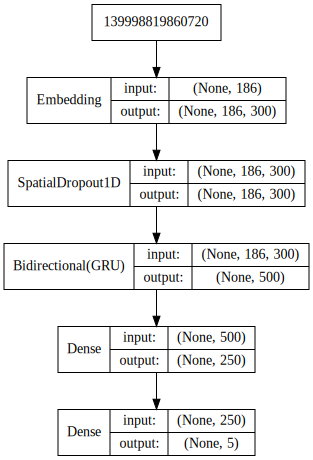

In [11]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

mw = ku.ModelWrapper(model, MODEL_NAME, LABEL_COLUMN, DATA_FILE, 
                     embedding=EMBED_SIZE,
                     tokenizer=t)


network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0730 01:06:57.776680 140001736955776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 730s 11ms/step - loss: 0.9515 - acc: 0.6360 - val_loss: 0.8539 - val_acc: 0.6659
Epoch 2/50
67225/67225 [==============================] - 301s 4ms/step - loss: 0.7863 - acc: 0.6936 - val_loss: 0.8478 - val_acc: 0.6720
Epoch 3/50
67225/67225 [==============================] - 296s 4ms/step - loss: 0.7021 - acc: 0.7275 - val_loss: 0.8608 - val_acc: 0.6700
Epoch 4/50
67225/67225 [==============================] - 301s 4ms/step - loss: 0.6188 - acc: 0.7636 - val_loss: 0.9167 - val_acc: 0.6594
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


In [13]:
mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))


Running model.evaluate...
28011/28011 [==============================] - 199s 7ms/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...
Accuracy: 67.76%


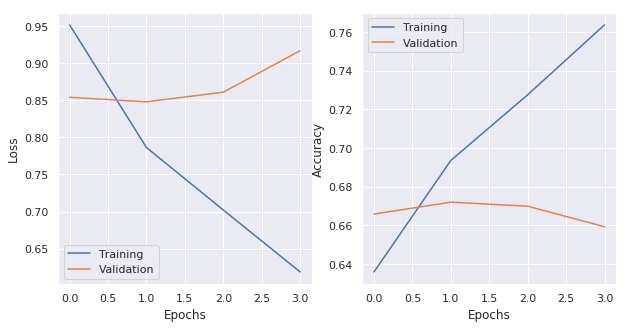

In [14]:
pu.plot_network_history(mw.network_history)

In [15]:
mw.confusion_matrix

array([[ 3446,    71,   158,    50,   243],
       [ 1141,    90,   287,   120,   233],
       [  734,   114,   628,   460,   595],
       [  258,    48,   414,  1234,  2798],
       [  309,    15,   197,   786, 13582]])

In [25]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.59      0.87      0.70      3968
           2       0.27      0.05      0.08      1871
           3       0.37      0.25      0.30      2531
           4       0.47      0.26      0.33      4752
           5       0.78      0.91      0.84     14889

    accuracy                           0.68     28011
   macro avg       0.49      0.47      0.45     28011
weighted avg       0.63      0.68      0.63     28011



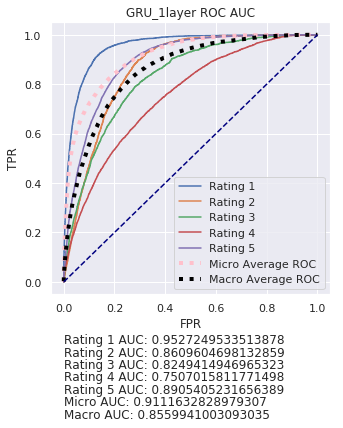

In [17]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

### Save off various files

In [18]:
mw.save(DRIVE_DIR)

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_1layer-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_1layer-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_1layer-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


In [19]:
mw.get_report().to_df()

,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.677591,"{""1"": {""precision"": 0.5852581521739131, ""recal...","[[3446, 71, 158, 50, 243], [1141, 90, 287, 120...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,32.59,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.835665,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_1layer,<keras.callbacks.History object at 0x7f5403610...,32.59,"{""auc_1"": 0.9527249533513878, ""auc_2"": 0.86096...",success,2019-07-30 01:46:31,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.0078125,...",84032.0,186.0,32.59


In [23]:
# test to see if report has been written properly
loaded = pd.read_csv(mw.report_file, quotechar="'")
loaded

,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.677591,"{""1"": {""precision"": 0.5852581521739131, ""recal...","[[3446, 71, 158, 50, 243], [1141, 90, 287, 120...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,32.59,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.835665,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_1layer,<keras.callbacks.History object at 0x7f5403610...,32.59,"{""auc_1"": 0.9527249533513878, ""auc_2"": 0.86096...",success,2019-07-30 01:46:31,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.0078125,...",84032.0,186.0,32.59
1,0.666845,"{""1"": {""precision"": 0.6141875505254648, ""recal...","[[3039, 150, 206, 95, 385], [892, 132, 293, 16...",review_body-word2vec5-111909-512-nolda-DNN_340...,word2vec,10.98,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.866301,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_340_batchnorm,<keras.callbacks.History object at 0x7f976c0f4...,10.98,"{""auc_1"": 0.9450905669619495, ""auc_2"": 0.84615...",success,2019-07-30 01:50:37,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00103225...",83931.0,512.0,10.98
2,0.679019,"{""1"": {""precision"": 0.6480066102045032, ""recal...","[[3137, 62, 476, 40, 253], [843, 60, 603, 132,...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,8.79,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.823435,186.0,drive/My Drive/Springboard/capstone/models/ama...,biGRU_1layer_attention,<keras.callbacks.History object at 0x7f6df2f58...,8.79,"{""auc_1"": 0.9540099546947473, ""auc_2"": 0.86369...",success,2019-07-30 01:51:39,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.01058467...",84032.0,186.0,8.79
3,0.668990,"{""1"": {""precision"": 0.6134569850039463, ""recal...","[[3109, 147, 201, 93, 325], [911, 128, 310, 19...",review_body-word2vec5-111909-512-nolda-DNN_384...,word2vec,17.84,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.846571,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_384_384,<keras.callbacks.History object at 0x7fab83bd1...,17.84,"{""auc_1"": 0.9488228396143968, ""auc_2"": 0.85419...",success,2019-07-30 01:58:04,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,17.84
4,0.668704,"{""1"": {""precision"": 0.5902151922015818, ""recal...","[[3209, 64, 239, 83, 280], [994, 75, 341, 179,...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,4.85,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.848801,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128,<keras.callbacks.History object at 0x7f87970b1...,4.85,"{""auc_1"": 0.9489704320035117, ""auc_2"": 0.85306...",success,2019-07-30 01:58:55,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00051612...",83931.0,512.0,4.85


In [24]:
print(datetime.now())

2019-07-30 02:02:21.425965
